In [1]:
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2023-10-31 15:21:14.441918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 15:21:14.442031: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 15:21:14.442059: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 15:21:14.449742: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_folder_path =os.listdir(Path(os.getcwd()+ r"/Dataset/FoodSeg103/Images"))


# print(os.listdir(Path(os.getcwd()+ r"/Dataset/FoodSeg103")))
print(data_folder_path)
# os.getcwd()



['ann_dir', 'img_dir']


In [3]:
##Constants
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_CLASSES = 256
NUM_TRAIN_IMAGES = 100
NUM_VAL_IMAGES = 20


In [4]:
# train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_images = os.listdir(Path(os.getcwd()+ r"/Dataset/FoodSeg103/Images/img_dir/train"))[:NUM_TRAIN_IMAGES]
train_masks = os.listdir(Path(os.getcwd()+ r"/Dataset/FoodSeg103/Images/ann_dir/train"))[:NUM_TRAIN_IMAGES]
val_images = os.listdir(Path(os.getcwd()+ r"/Dataset/FoodSeg103/Images/img_dir/train"))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = os.listdir(Path(os.getcwd()+ r"/Dataset/FoodSeg103/Images/ann_dir/train"))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]

train_images = [str(Path(os.getcwd() + '/Dataset/FoodSeg103/Images/img_dir/train', img)) for img in train_images]
train_masks = [str(Path(os.getcwd() + '/Dataset/FoodSeg103/Images/ann_dir/train', img)) for img in train_masks]
val_images = [str(Path(os.getcwd() + '/Dataset/FoodSeg103/Images/img_dir/train', img)) for img in val_images]
val_masks = [str(Path(os.getcwd() + '/Dataset/FoodSeg103/Images/ann_dir/train', img)) for img in val_masks]



In [5]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [6]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float32, name=None))>


2023-10-31 15:21:28.029471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-31 15:21:28.032330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-31 15:21:28.032369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-31 15:21:28.034207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-31 15:21:28.034235: I tensorflow/compile

In [7]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [8]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

Epoch 1/25


2023-10-31 15:27:20.685874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-31 15:27:21.415742: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-31 15:27:21.599687: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-31 15:27:23.976109: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd7a91e33e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 15:27:23.976144: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-10-31 15:27:23.979692: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 15:27:24.032179: I ./tensorflow/compiler/jit/device_comp

25/25 [==============================] - 31s 216ms/step - loss: 5.3528 - accuracy: 0.0040 - val_loss: 11784.5723 - val_accuracy: 9.3689e-04
Epoch 2/25
25/25 [==============================] - 4s 149ms/step - loss: 4.7797 - accuracy: 0.0083 - val_loss: 1945.4413 - val_accuracy: 0.0010
Epoch 3/25
25/25 [==============================] - 4s 150ms/step - loss: 4.5624 - accuracy: 0.0117 - val_loss: 970.3334 - val_accuracy: 0.0010
Epoch 4/25
25/25 [==============================] - 4s 152ms/step - loss: 4.4456 - accuracy: 0.0126 - val_loss: 268.9156 - val_accuracy: 9.3384e-04
Epoch 5/25
25/25 [==============================] - 3s 138ms/step - loss: 4.4032 - accuracy: 0.0134 - val_loss: 71.5765 - val_accuracy: 0.0013
Epoch 6/25
25/25 [==============================] - 3s 139ms/step - loss: 4.4029 - accuracy: 0.0133 - val_loss: 232.9867 - val_accuracy: 0.0012
Epoch 7/25
25/25 [==============================] - 3s 136ms/step - loss: 4.3478 - accuracy: 0.0147 - val_loss: 10.1923 - val_accuracy: 

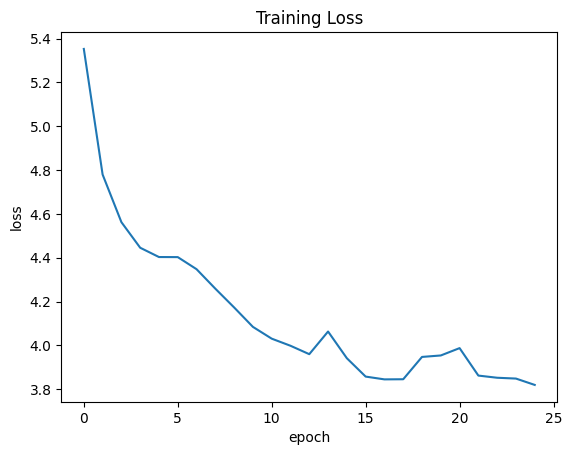

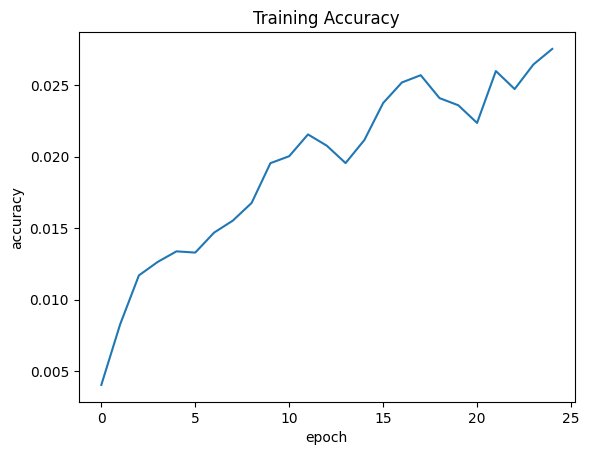

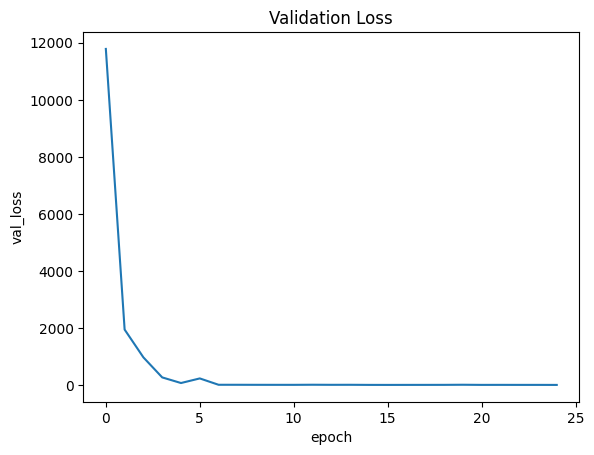

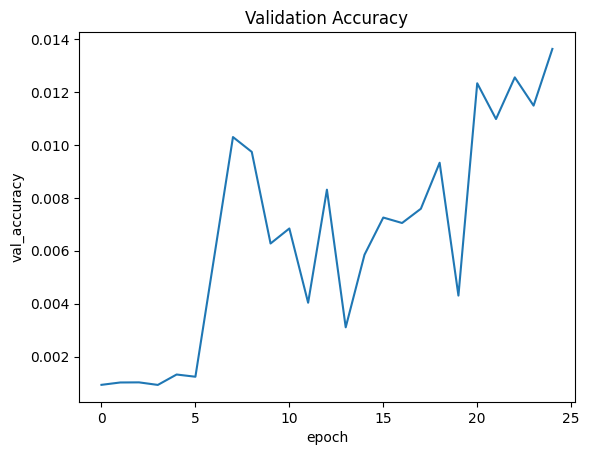

In [9]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()